In [458]:
# Department: ESTSOFT
# Class: AI Modelling
# Category: Machine learning
# Title: Electricity consumption prediction
# Contributors: Jeong Gukho, Jeong Woogun, Kim Hyungeun, Kim Juneon, Kimm Soo Min
# Last modified date: 01/04/25

### **Library**

In [ ]:
# Library
# Time
from timeit import default_timer as timer
import time
from tqdm.auto import tqdm

# File
import os
import requests
import zipfile
from pathlib import Path
from PIL import Image
import random
import chardet

# Numerical & Data Handling
import numpy as np
import pandas as pd
import scipy as sp
import math

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
from sklearn.tree import plot_tree
from scipy.optimize import curve_fit

# Machine Learning Libraries
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor, 
							  ExtraTreesClassifier, ExtraTreesRegressor, 
							  BaggingClassifier, BaggingRegressor, 
							  GradientBoostingClassifier, GradientBoostingRegressor, 
							  AdaBoostClassifier, AdaBoostRegressor, 
							  VotingClassifier, VotingRegressor,
							  StackingClassifier, StackingRegressor)
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from mlxtend.frequent_patterns import apriori, association_rules
import xgboost as xgb , XGBRegressor

# Neural Network Libraries
import torch
from torch import nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import huggingface
import keras
import tensorflow
from transformers import pipeline

# Feature Engineering
from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, Normalizer, 
								   LabelEncoder, OneHotEncoder, OrdinalEncoder, LabelBinarizer)
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, RFE, SequentialFeatureSelector, VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from mlxtend.preprocessing import TransactionEncoder
from hyperopt import hp, tpe, fmin, Trials

# Dimensionality Reduction
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

# Time-Series Analysis
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Evaluation
from sklearn.metrics import (classification_report, pairwise_distances, silhouette_score, 
							 roc_curve, auc, roc_auc_score, RocCurveDisplay, 
							 confusion_matrix, ConfusionMatrixDisplay, 
							 accuracy_score, recall_score, precision_score, f1_score,
							 log_loss, hinge_loss, mean_absolute_error, mean_squared_error, r2_score)
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC, ConfusionMatrix, MeanSquaredError, MeanAbsoluteError, R2Score, MetricCollection
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


### **Data Preparation**

**Data source**

1. 한국전력공사(KEPCO) - https://bigdata.kepco.co.kr/cmsmain.do?scode=S01&pcode=000171&redirect=Y
2. 기상청 - https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36


**Electricity consumption**
- 840 samples in total
- Jan 2015 to Dec 2024
- 7 different locations
 	- Seoul
	- Incheon
	- Daejeon 
	- Daeguu
	- Ulsann
	- Gwangjuu
	- Busan
- 9 Features
	- Year
	- Month
	- Province
	- Number of Households
	- Avg Power Consumption per Household (kWh)
	- Avg Electricity Bill per Household (KRW)
	- Number of Tropical Nights
	- Number of Heatwave Days
	- Number of Coldwave Days

In [460]:
# Load electricity consumption data
df_electricity = pd.read_csv('data/electricity_consumption_eng.csv', encoding='utf-8')
df_electricity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Year                                       840 non-null    int64 
 1   Month                                      840 non-null    int64 
 2   Province                                   840 non-null    object
 3   Number of Households                       840 non-null    int64 
 4   Avg Power Consumption per Household (kWh)  840 non-null    int64 
 5   Avg Electricity Btill per Household (KRW)  840 non-null    int64 
 6   Number of Tropical Nights                  840 non-null    int64 
 7   Number of Heatwave Days                    840 non-null    int64 
 8   Number of Coldwave Days                    840 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 59.2+ KB


**Weather forecast**
- 861 samples in total
- Jan 2015 to Feb 2025
- 7 different locations
 	- Seoul
	- Incheon
	- Daejeon 
	- Daegu
	- Ulsan
	- Gwangju
	- Busan
- 21 Features
	- Station Name                  
	- Year                            
	- Month                          
	- Avg Temperature (Celsius)      
	- Avg Max Temperature (Celsius) 
	- Avg Min Temperature (Celsius) 
	- Avg Local Pressure (hPa)      
	- Avg Sea Level Pressure (hPa)  
	- Avg Vapor Pressure (hPa)      
	- Avg Dew Point Temp (Celsius)  
	- Avg Relative Humidity (%)     
	- Monthly Precipitation (mm)    
	- Small Pan Evaporation (mm)    
	- Avg Wind Speed (m/s)          
	- Max Wind Speed (m/s)          
	- Avg Cloud Cover (1/10)        
	- Total Sunshine Hours (hr)     
	- Sunshine Rate (%)             
	- Total Solar Radiation (MJ/m^2)
	- Avg Min Surface Temp (Celsius)
	- Avg Ground Temp (Celsius) 

In [461]:
# Load weather forecast data
df_weather = pd.read_csv('data/weather_forecast_eng.csv', encoding='utf-8')
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Station Name                    861 non-null    object 
 1   Year                            861 non-null    int64  
 2   Month                           861 non-null    int64  
 3   Avg Temperature (Celsius)       861 non-null    float64
 4   Avg Max Temperature (Celsius)   861 non-null    float64
 5   Avg Min Temperature (Celsius)   861 non-null    float64
 6   Avg Local Pressure (hPa)        861 non-null    float64
 7   Avg Sea Level Pressure (hPa)    861 non-null    float64
 8   Avg Vapor Pressure (hPa)        861 non-null    float64
 9   Avg Dew Point Temp (Celsius)    861 non-null    float64
 10  Avg Relative Humidity (%)       861 non-null    int64  
 11  Monthly Precipitation (mm)      861 non-null    float64
 12  Small Pan Evaporation (mm)      728 

In [462]:
# Check missing values
print(df_weather.isnull().sum())

Station Name                        0
Year                                0
Month                               0
Avg Temperature (Celsius)           0
Avg Max Temperature (Celsius)       0
Avg Min Temperature (Celsius)       0
Avg Local Pressure (hPa)            0
Avg Sea Level Pressure (hPa)        0
Avg Vapor Pressure (hPa)            0
Avg Dew Point Temp (Celsius)        0
Avg Relative Humidity (%)           0
Monthly Precipitation (mm)          0
Small Pan Evaporation (mm)        133
Avg Wind Speed (m/s)                0
Max Wind Speed (m/s)                0
Avg Cloud Cover (1/10)              6
Total Sunshine Hours (hr)           0
Sunshine Rate (%)                   0
Total Solar Radiation (MJ/m^2)     97
Avg Min Surface Temp (Celsius)      0
Avg Ground Temp (Celsius)           0
dtype: int64


In [463]:
# Handle missing values w/ ffill
df_weather.ffill(inplace=True)

In [464]:
# Re-check missing values
print(df_weather.isnull().sum())

Station Name                      0
Year                              0
Month                             0
Avg Temperature (Celsius)         0
Avg Max Temperature (Celsius)     0
Avg Min Temperature (Celsius)     0
Avg Local Pressure (hPa)          0
Avg Sea Level Pressure (hPa)      0
Avg Vapor Pressure (hPa)          0
Avg Dew Point Temp (Celsius)      0
Avg Relative Humidity (%)         0
Monthly Precipitation (mm)        0
Small Pan Evaporation (mm)        0
Avg Wind Speed (m/s)              0
Max Wind Speed (m/s)              0
Avg Cloud Cover (1/10)            0
Total Sunshine Hours (hr)         0
Sunshine Rate (%)                 0
Total Solar Radiation (MJ/m^2)    0
Avg Min Surface Temp (Celsius)    0
Avg Ground Temp (Celsius)         0
dtype: int64


In [465]:
# Create Date column using Year and Month columns
df_electricity['Date'] = pd.to_datetime(arg=dict(year=df_electricity['Year'], month=df_electricity['Month'], day=1))
df_weather['Date'] = pd.to_datetime(arg=dict(year=df_weather['Year'], month=df_weather['Month'], day=1))

# Drop Year and Month columns
df_weather = df_weather.drop(columns=['Year', 'Month'])

# Rename Station Name and Province to Location
df_electricity = df_electricity.rename(columns={'Province': 'Location'})
df_weather = df_weather.rename(columns={'Station Name': 'Location'})

# Merge df_weather and df_electricity based on Date and Location
df_merged = pd.merge(df_electricity, df_weather, on=['Date', 'Location'], how='inner') # Inner join based on Date and Location
df_merged = df_merged[['Date'] + [col for col in df_merged.columns if col != 'Date']] # Bring Date column to the front
df_merged.to_csv('data/merged_data.csv', index=False, encoding='utf-8')

In [466]:
df_merged.columns

Index(['Date', 'Year', 'Month', 'Location', 'Number of Households',
       'Avg Power Consumption per Household (kWh)',
       'Avg Electricity Btill per Household (KRW)',
       'Number of Tropical Nights', 'Number of Heatwave Days',
       'Number of Coldwave Days', 'Avg Temperature (Celsius)',
       'Avg Max Temperature (Celsius)', 'Avg Min Temperature (Celsius)',
       'Avg Local Pressure (hPa)', 'Avg Sea Level Pressure (hPa)',
       'Avg Vapor Pressure (hPa)', 'Avg Dew Point Temp (Celsius)',
       'Avg Relative Humidity (%)', 'Monthly Precipitation (mm)',
       'Small Pan Evaporation (mm)', 'Avg Wind Speed (m/s)',
       'Max Wind Speed (m/s)', 'Avg Cloud Cover (1/10)',
       'Total Sunshine Hours (hr)', 'Sunshine Rate (%)',
       'Total Solar Radiation (MJ/m^2)', 'Avg Min Surface Temp (Celsius)',
       'Avg Ground Temp (Celsius)'],
      dtype='object')

### **Visualization**

In [467]:
def dual_mean_plot(a: str,b: str, c='Month'):
	'''
	This function generates a dual-axis plot to visualize a and b averaged on c.

	Parameters:
	a (str): Column name for data in the DataFrame to compare.
	b (str): Column name for data in the DataFrame to compare.
	c (str): Column name for data in the DataFrame to set average on.

	Output:
	A dual-axis plot with bars of a and an line of b averaged on c.
	'''

	monthly_data = df_merged.groupby(c)[[a,b]].mean().reset_index()
	fig, ax_1 = plt.subplots(figsize=(12, 8))
	ax_1.set_xlabel(f'{c}')
	ax_1.set_ylabel(f'{a}')
	ax_1.bar(monthly_data[c], monthly_data[a], color='orange')
	ax_1.tick_params(axis='y', labelcolor='orange')
	#######
	ax_2 = ax_1.twinx()
	ax_2.set_ylabel(f'{b}')
	ax_2.plot(monthly_data[c], monthly_data[b], marker='o', color='blue')
	ax_2.tick_params(axis='y', labelcolor='blue')
	plt.title(f'{a} & {b} from 2015 to 2024')
	plt.grid()
	plt.tight_layout()

	plt.show()

In [468]:
def one_feature_two_group (a,b:str,c:str): #a: Main Category b:Subcategory c:feature ex)서울, 감수량,가구
	"""
	Plots the mean of a single feature 'c' grouped by two categorical variables 'a' and 'b'.
	
	Parameters:
	a (str): Name of the main category column in df_merged (e.g., a higher-level group like 'Region').
	b (str): Name of the subcategory column in df_merged (e.g., a more granular group like 'City').
	c (str): Name of the feature/metric column whose mean is to be plotted (e.g., 'Sales').
	"""
	df_mean=df_merged.groupby([f'{a}',f'{b}'])[c].mean()
	plt.figure(figsize=(12, 8))
	unstacked_df = df_mean.unstack(level=f'{a}')
	unstacked_df .plot(kind='line',marker='o',ax=plt.gca())

	plt.xlabel(f'{b}')
	plt.ylabel(f'{c}')
	plt.grid()
	plt.title(f'{c} by {a} and {b}')

In [469]:
# #filterheatmap
# df_numeric=df_merged.select_dtypes(include=['number'])
# df_corr=X_train.corr()
# filter_corr=df_corr[abs(df_corr)>=0.8]
# plt.figure(figsize=(20,20))
# sns.heatmap(filter_corr, annot=True,vmin=-1, cmap='coolwarm')
# plt.title('Correlation Heatmap')
# plt.show()

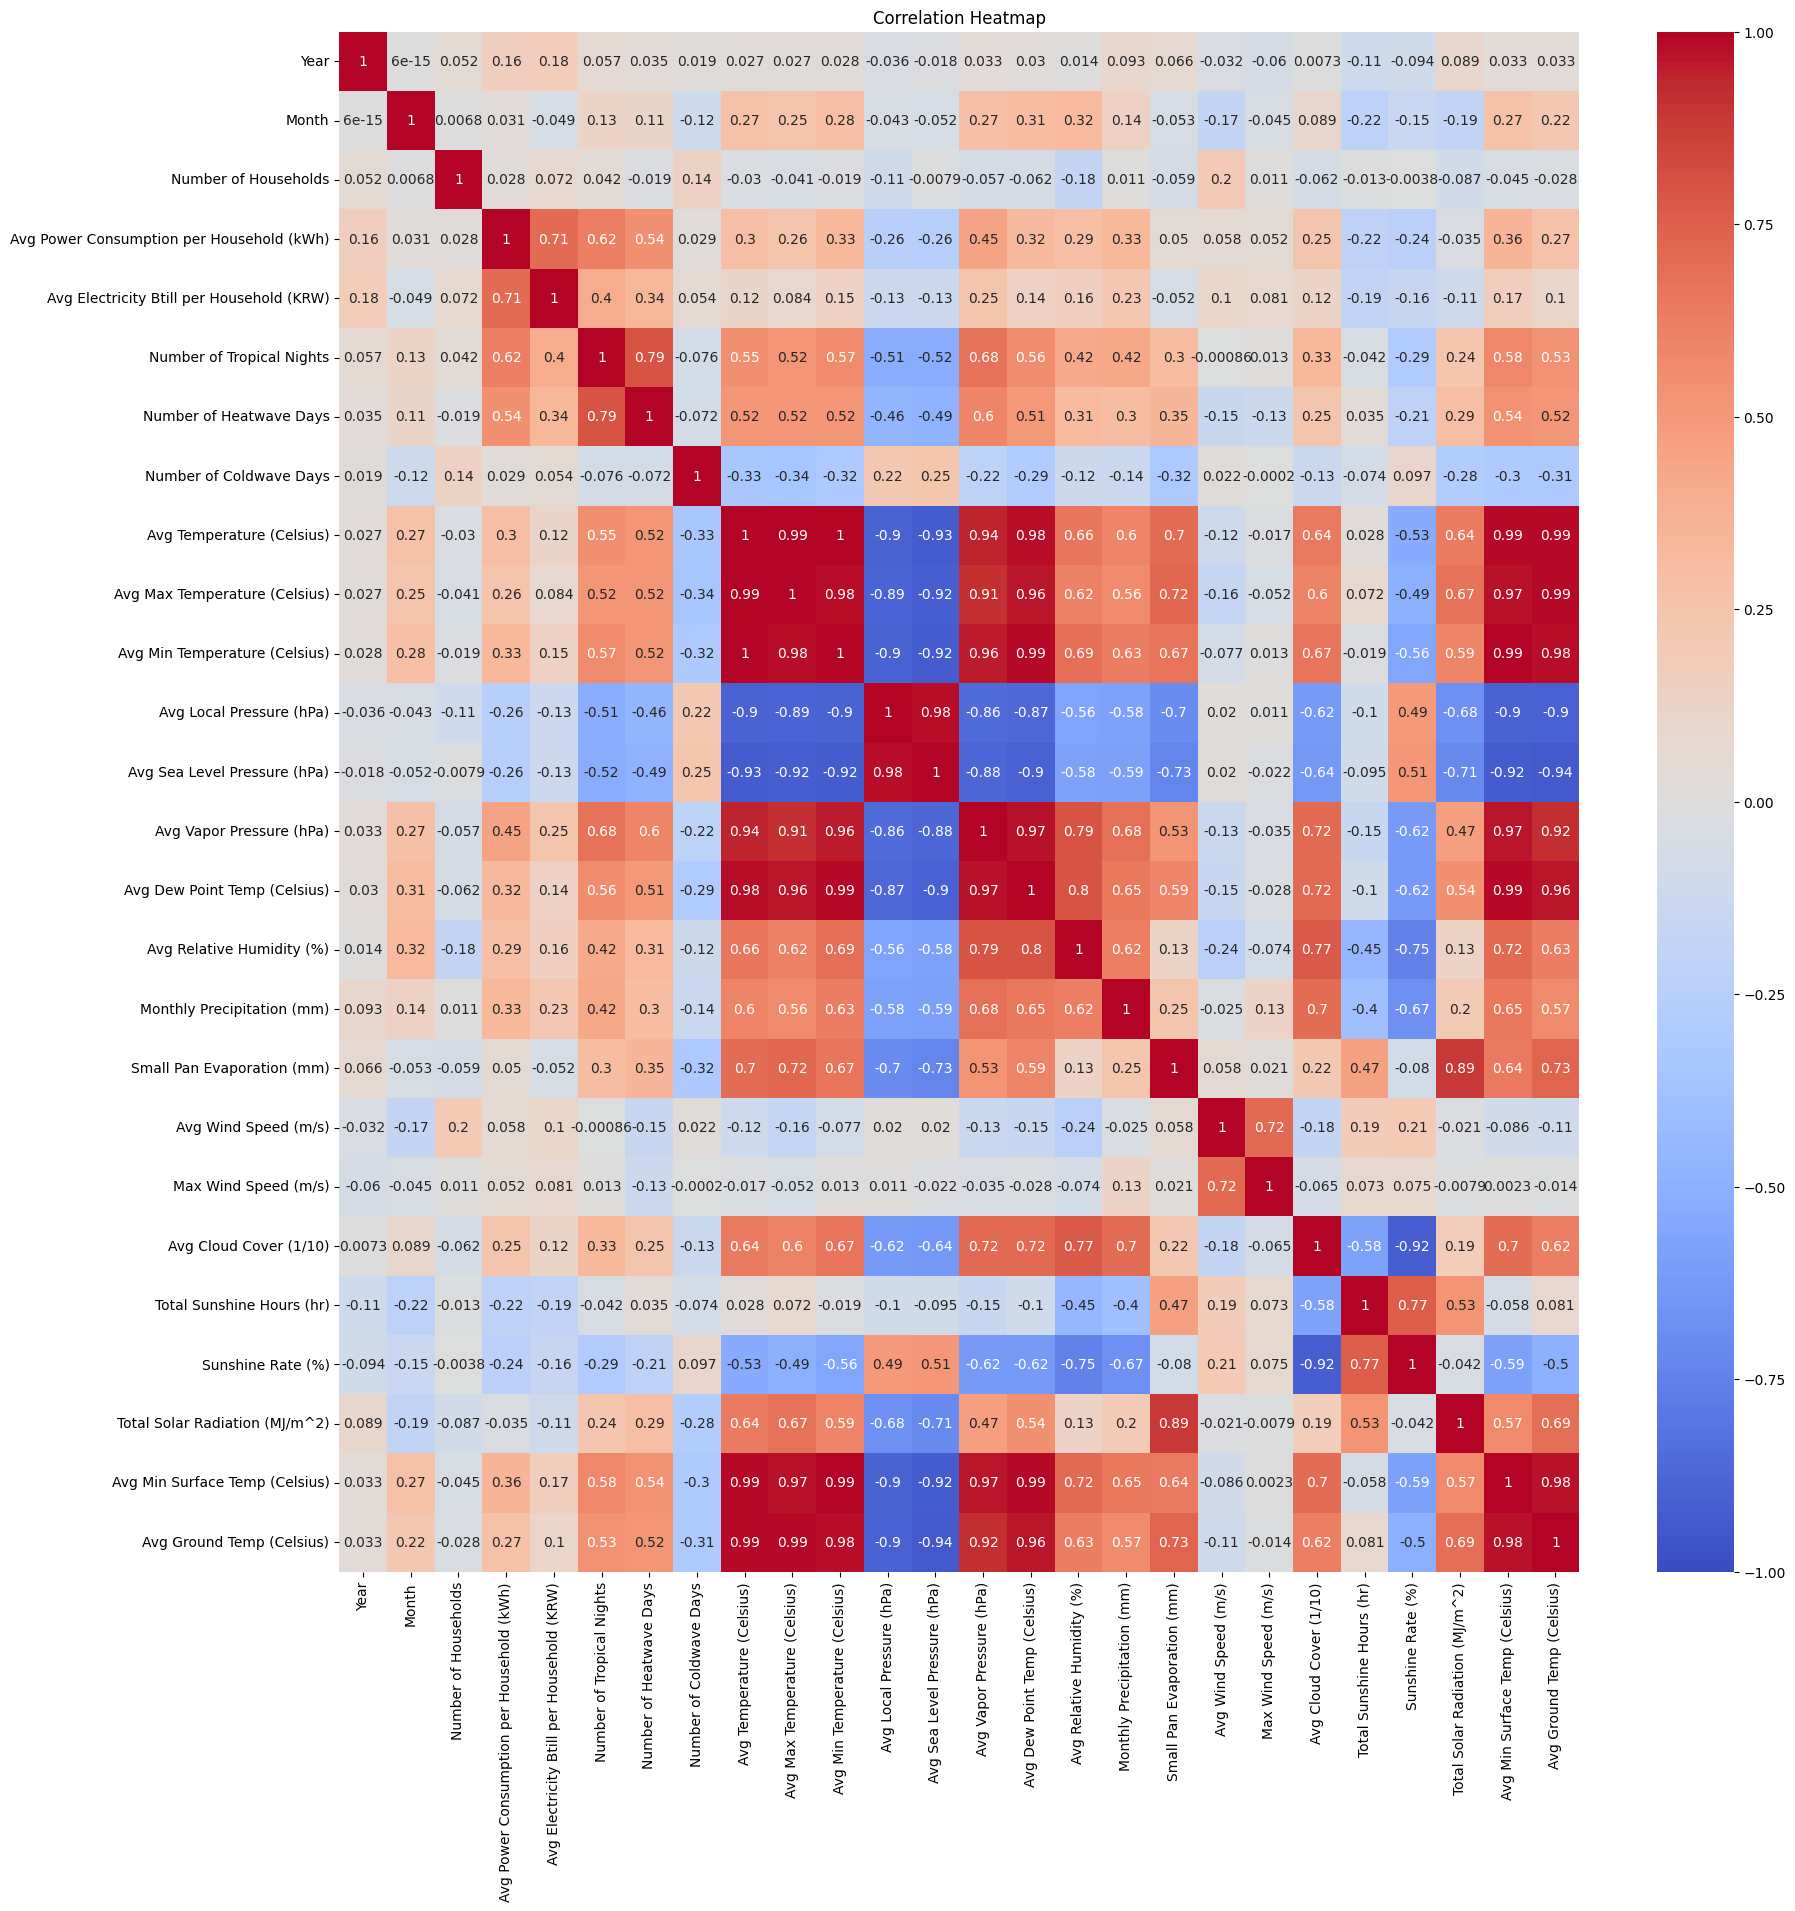

In [470]:
#heatmap
df_numeric=df_merged.select_dtypes(include=['number'])
df_corr=df_numeric.corr()
# df_corr_find = df_corr.copy()
# low_cols = df_corr_find[abs(df_corr_find['Avg Power Consumption per Household (kWh)'])<0.2].index
filter_corr=df_corr[abs(df_corr)>=0.1]
plt.figure(figsize=(20,20))
sns.heatmap(df_corr, annot=True,vmin=-1, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

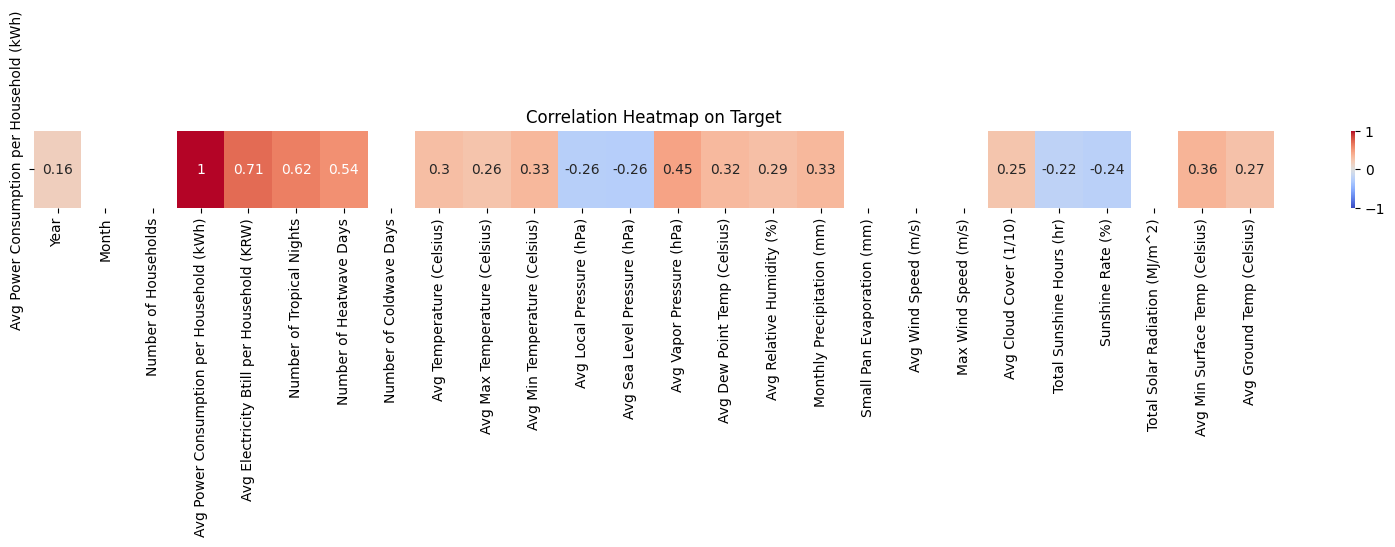

In [471]:
#heatmap
df_numeric=df_merged.select_dtypes(include=['number'])
df_corr=df_numeric.corr()
# df_corr_find = df_corr.copy()
# low_cols = df_corr_find[abs(df_corr_find['Avg Power Consumption per Household (kWh)'])<0.2].index
df_corr=df_corr.loc[['Avg Power Consumption per Household (kWh)']]
filter_corr=df_corr[abs(df_corr)>=0.1]
plt.figure(figsize=(20,1))
sns.heatmap(filter_corr, annot=True,vmin=-1, cmap='coolwarm')
plt.title('Correlation Heatmap on Target')
plt.show()

In [472]:
print(low_cols) 

Index(['Number of Households', 'Number of Coldwave Days', 'Year', 'Month',
       'Small Pan Evaporation (mm)', 'Avg Wind Speed (m/s)',
       'Max Wind Speed (m/s)', 'Total Solar Radiation (MJ/m^2)'],
      dtype='object')


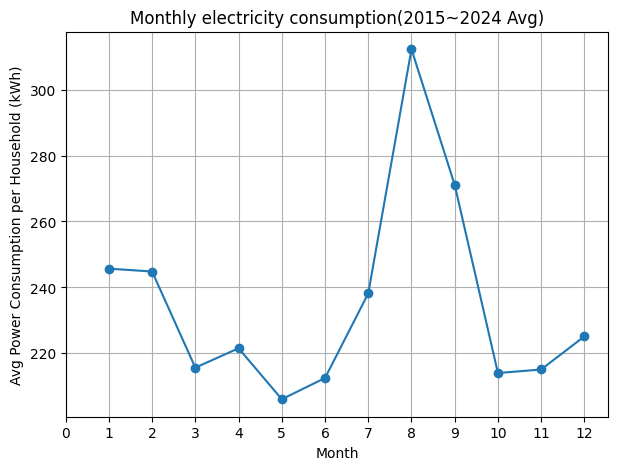

In [473]:
# Monthly Avg electricity consumption barplot

ele_plt = df_merged.groupby('Month')['Avg Power Consumption per Household (kWh)'].mean()

plt.figure(figsize=(7, 5))
ele_plt.plot(kind='line', marker='o')
plt.title("Monthly electricity consumption(2015~2024 Avg)")
plt.xlabel("Month")
plt.ylabel("Avg Power Consumption per Household (kWh)")
plt.xticks(np.arange(0,13,1),rotation=0)
plt.grid()
plt.show()

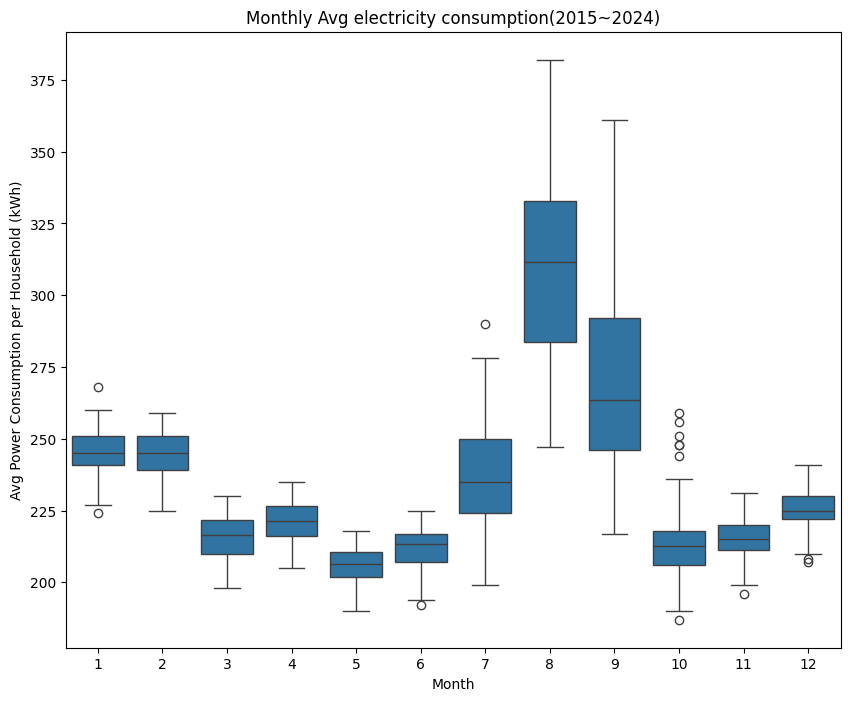

In [474]:
# Monthly Avg electricity consumption boxplot

plt.figure(figsize=(10, 8))
sns.boxplot(data=df_merged, x='Month', y='Avg Power Consumption per Household (kWh)')
plt.title("Monthly Avg electricity consumption(2015~2024)")
plt.xlabel("Month")
plt.ylabel("Avg Power Consumption per Household (kWh)")
plt.show()

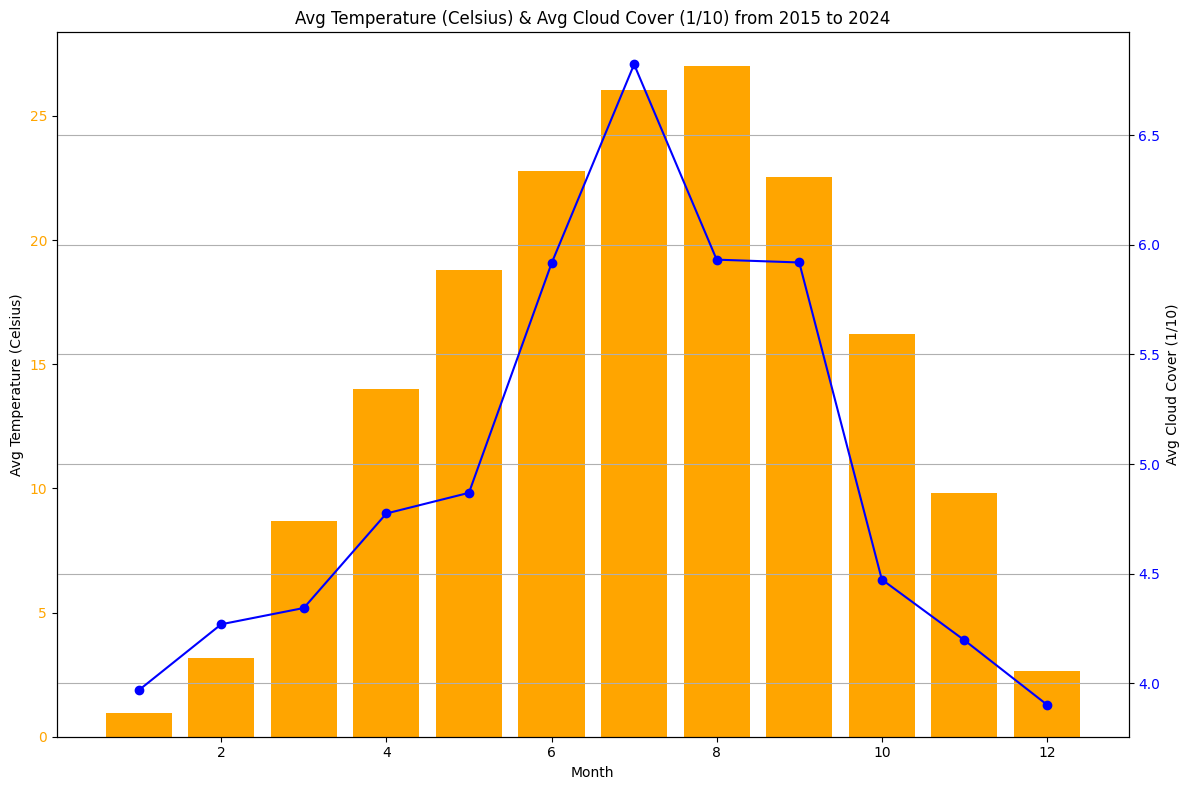

In [475]:
# Monthly temperature plot
dual_mean_plot(a='Avg Temperature (Celsius)', b='Avg Cloud Cover (1/10)', c='Month')


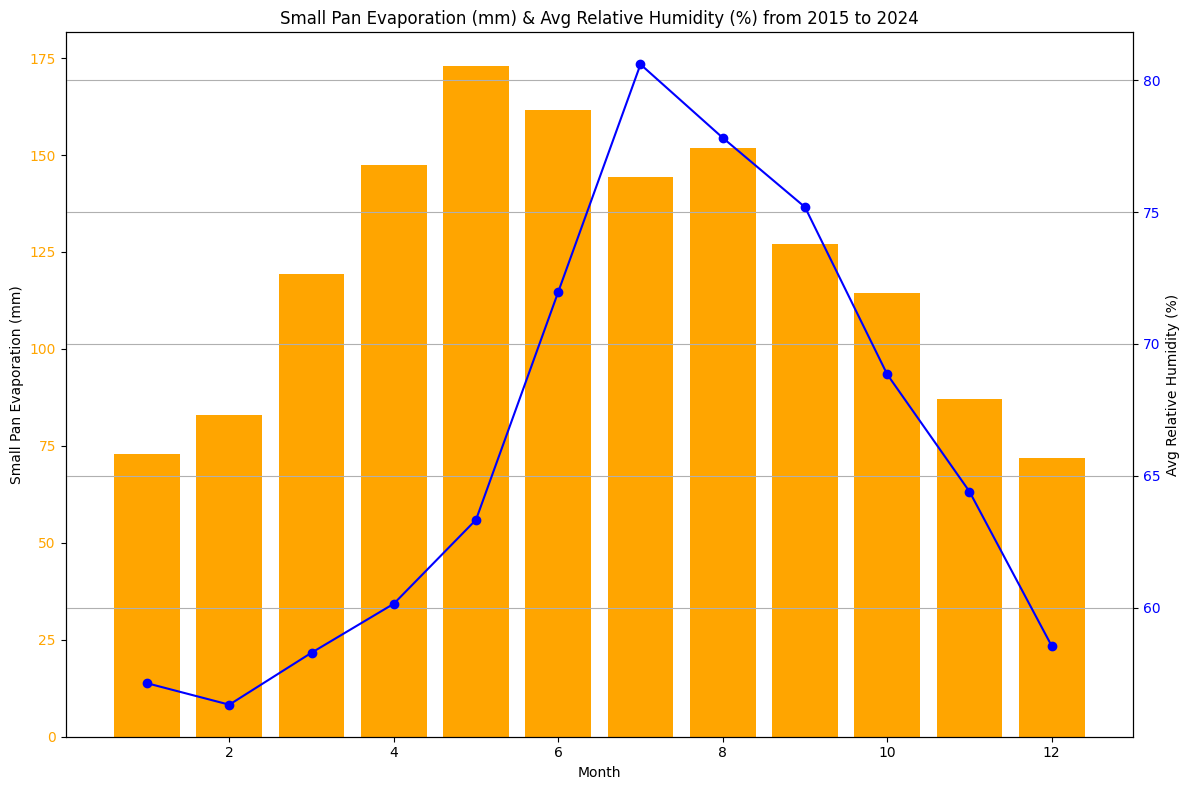

In [476]:
# Number of heatwave days and avg power consumption per household by year
dual_mean_plot(a='Small Pan Evaporation (mm)',b='Avg Relative Humidity (%)',c='Month')

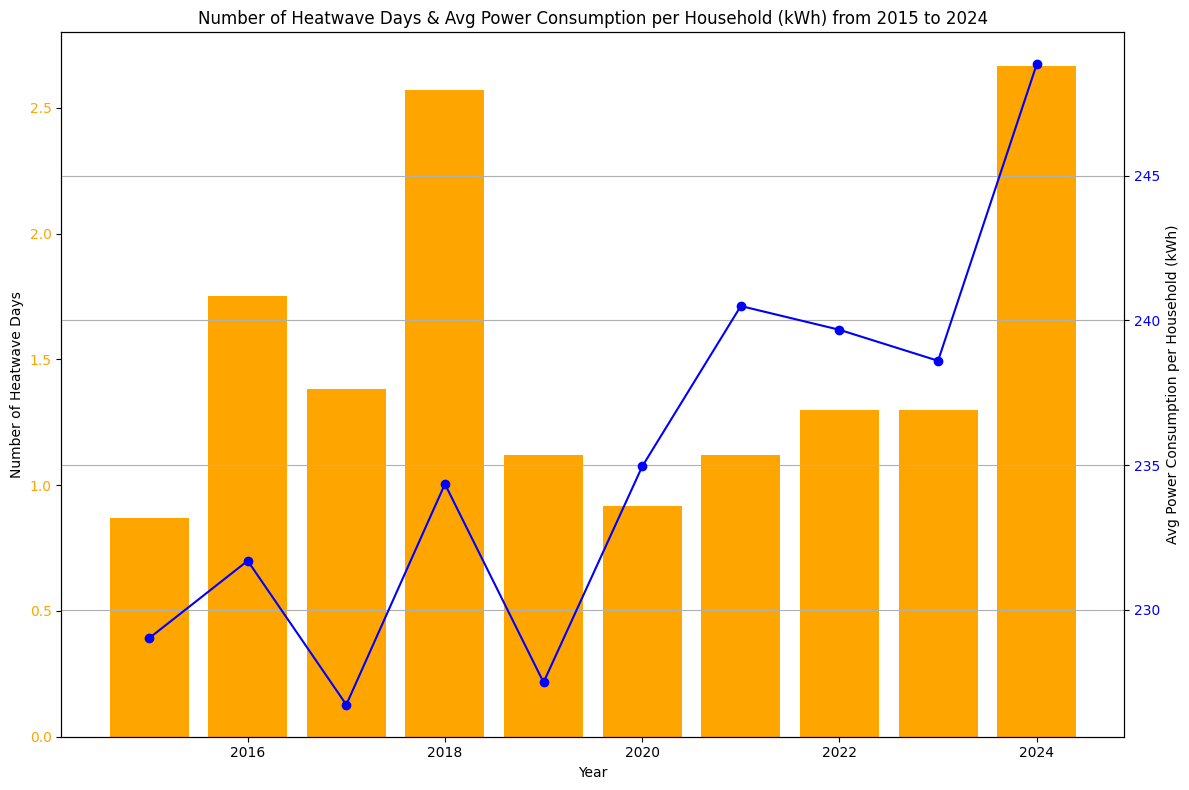

In [477]:
# Number of heatwave days and avg power consumption per household by year
dual_mean_plot(a='Number of Heatwave Days',b='Avg Power Consumption per Household (kWh)',c='Year')


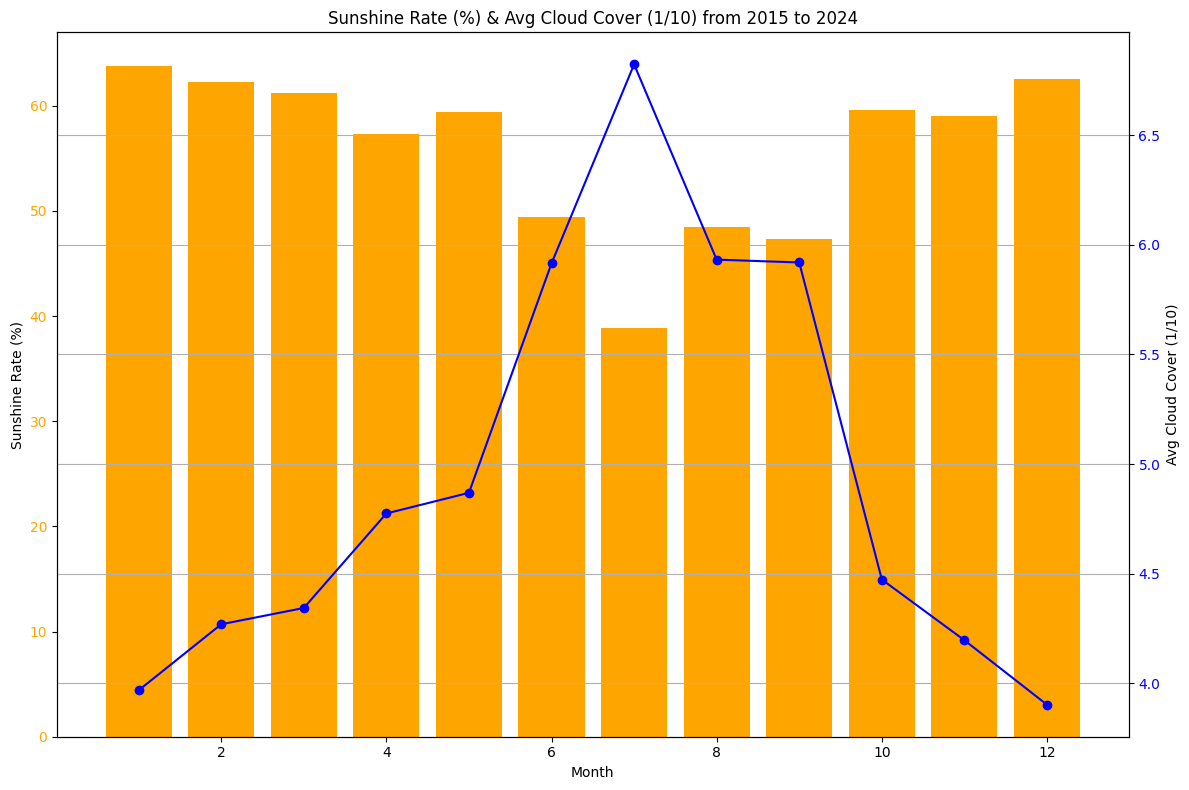

In [478]:
# Sunshine and avg cloud cover by month
dual_mean_plot(a='Sunshine Rate (%)', b='Avg Cloud Cover (1/10)', c='Month')

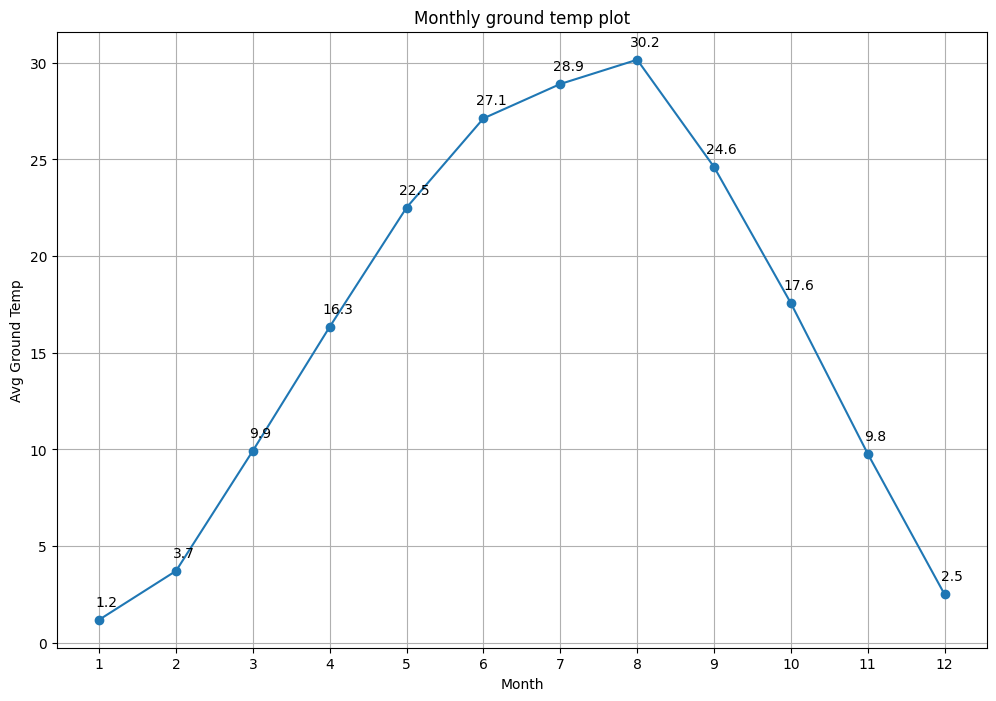

In [479]:
# Monthly ground temp plot(month)
df=df_merged.copy()
#Avg Ground Temp (Celsius)  
df_sum=df.groupby('Month')['Avg Ground Temp (Celsius)'].sum()
df_mean=df.groupby('Month')['Avg Ground Temp (Celsius)'].mean()
plt.figure(figsize=(12, 8))
df_mean.plot(kind='line',marker='o')
plt.xticks(df_mean.index)
plt.xlabel('Month')
plt.ylabel('Avg Ground Temp')
plt.title('Monthly ground temp plot')
for x_val, y_val in df_mean.items():
	plt.text(x_val+0.1,y_val+0.55,f'{y_val:.1f}',ha='center',va='bottom',fontsize=10)
plt.grid()
plt.show()

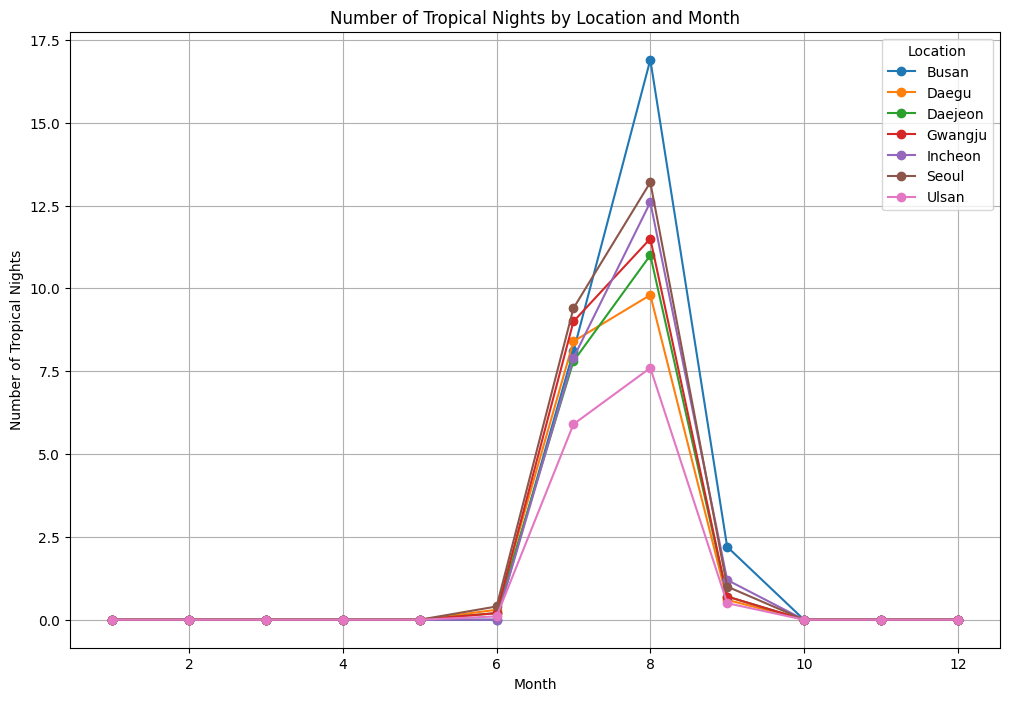

In [480]:
one_feature_two_group('Location','Month','Number of Tropical Nights')

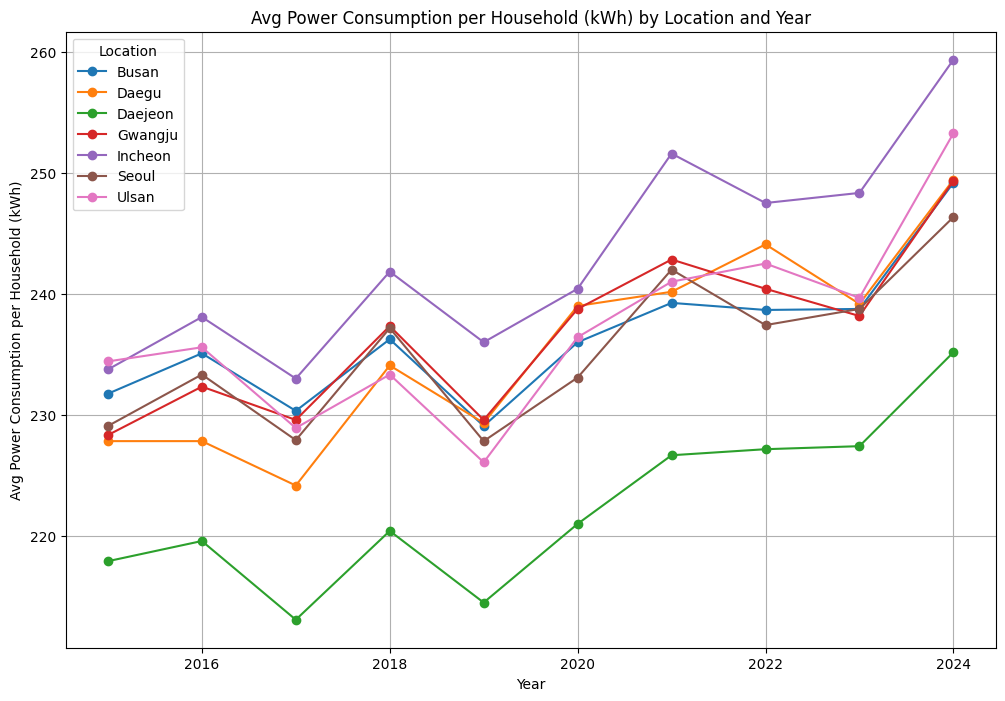

In [481]:
one_feature_two_group('Location','Year','Avg Power Consumption per Household (kWh)')

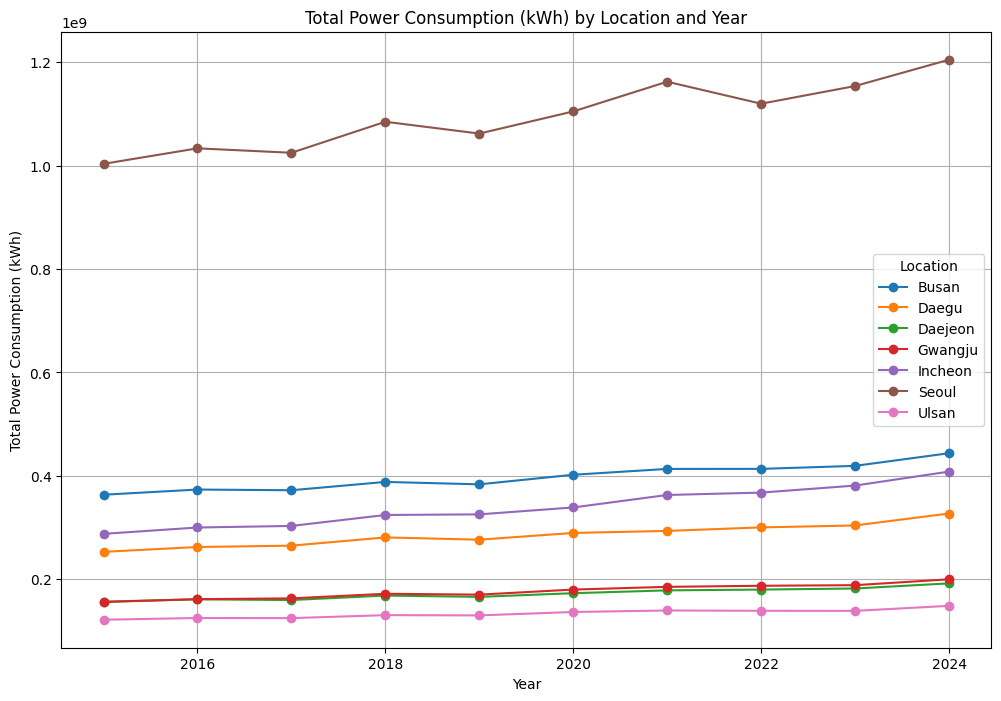

In [482]:
df_merged['Total Power Consumption (kWh)'] = df_merged['Number of Households'] * df_merged['Avg Power Consumption per Household (kWh)']
one_feature_two_group('Location','Year','Total Power Consumption (kWh)')

### **Data Preprocessing**

- Preprocessing steps safe to do before splitting
<br>

	- Remove obvious duplicates
	- Fix incorrect labels
	- Drop irrelevant columns
	- Basic data cleaning such as fixing typos or unifying units
	- Handling missing data if not based on global statistics such as dropping rows w/ missing target
	- Changing boolean type to 0 / 1
</br>

- Preprocessing steps that should happen after train-test split
<br>
	- Feature scaling / Normalisation
	- Encoding categorical variables
	- Dimensionality reduction
	- Outlier detection (if model is sensitive)
	- Feature selection based on correlation or variance
	- Creating time-based features if it involves future data
	- Data augmentation
</br>

In [483]:
# Drop timestamp
df_merged = df_merged.drop(columns=['Date'])

In [484]:
# Data split for features and target
X = df_merged.drop(columns=['Avg Power Consumption per Household (kWh)'])
y = df_merged['Avg Power Consumption per Household (kWh)']

In [485]:
# Grab column names of each data type
numerical_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
datetime_cols = X.select_dtypes(include=['datetime']).columns
target_col = y.name

In [486]:
# Data split for train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [487]:
# Location label encoding
label_encoder = LabelEncoder()
for col in categorical_cols:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])


In [488]:
# Scaling
scaler=StandardScaler()
X_train[numerical_cols]=scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols]=scaler.transform(X_test[numerical_cols])


In [489]:
# Check multicolinearity using VIF on training data
df_vif = pd.DataFrame()
df_vif['feature'] = X_train.columns
df_vif['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
df_vif

,feature,VIF
0,Year,1.306535
1,Month,2.480276
2,Location,1.223516
3,Number of Households,34.981957
4,Avg Electricity Btill per Household (KRW),1.695185
5,Number of Tropical Nights,5.689885
6,Number of Heatwave Days,3.979908
7,Number of Coldwave Days,1.457609
8,Avg Temperature (Celsius),5578.480849
9,Avg Max Temperature (Celsius),1305.825557


In [490]:
# Drop columns w/ multicolinearity
X_train = X_train.drop(columns=['Avg Max Temperature (Celsius)', 'Avg Min Temperature (Celsius)', 'Avg Dew Point Temp (Celsius)', 'Avg Sea Level Pressure (hPa)', 'Total Sunshine Hours (hr)', 'Total Solar Radiation (MJ/m^2)', 'Avg Min Surface Temp (Celsius)', 'Avg Ground Temp (Celsius)'])
X_test = X_test.drop(columns=['Avg Max Temperature (Celsius)', 'Avg Min Temperature (Celsius)', 'Avg Dew Point Temp (Celsius)', 'Avg Sea Level Pressure (hPa)', 'Total Sunshine Hours (hr)', 'Total Solar Radiation (MJ/m^2)', 'Avg Min Surface Temp (Celsius)', 'Avg Ground Temp (Celsius)'])

In [491]:
# Re-check multicolinearity
df_vif_removed = pd.DataFrame()
df_vif_removed['feature'] = X_train.columns
df_vif_removed['VIF'] = [variance_inflation_factor(X_train, i) for i in range(X_train.shape[1])]
df_vif_removed

,feature,VIF
0,Year,1.151240
1,Month,1.787952
2,Location,1.116859
3,Number of Households,31.394970
4,Avg Electricity Btill per Household (KRW),1.643817
5,Number of Tropical Nights,5.233764
6,Number of Heatwave Days,3.584983
7,Number of Coldwave Days,1.313608
8,Avg Temperature (Celsius),31.376433
9,Avg Local Pressure (hPa),9.068866


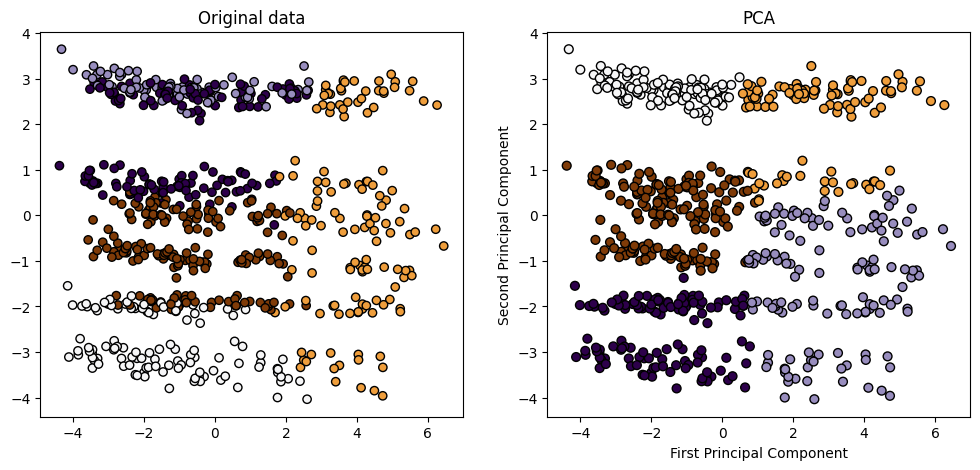

In [ ]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

'''
plt.figure(figsize=(6,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='PuOr', s=40, edgecolors='k')
plt.title("PCA")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.colorbar()
plt.show()
'''

# 흠.....

# K-Means 클러스터링 적용 (PCA 적용 전후 비교)
kmeans_original = KMeans(n_clusters=5, random_state=42, n_init=10)
y_pred_original = kmeans_original.fit_predict(X_train)

kmeans_pca = KMeans(n_clusters=5, random_state=42, n_init=10)
y_pred_pca = kmeans_pca.fit_predict(X_pca)

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# (좌) 원본 데이터 클러스터링
ax[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_original, cmap='PuOr', edgecolors='k')
ax[0].set_title("Original data")

# (우) PCA 변환 후 클러스터링
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_pca, cmap='PuOr', s=40,edgecolors='k')
ax[1].set_title("PCA")


plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

plt.show()

### **Modelling**

Run different machine learning models w/ hyperparameter tunings. <br>
Comparison of errors using RMSE, MAE, and adjusted R^2.
R^2 always increases when there are more features, so adjusted R^2 will penalise that impact.

In [504]:
def adj_r2_score(y_true, y_pred, p=X.shape[1]):
    """
    Compute the Adjusted R² (coefficient of determination).

    Adjusted R² adjusts the regular R² score for the number of predictors (features)
    in the model. It penalizes the R² score for adding unnecessary predictors, helping
    to avoid overfitting.

    Parameters:
    - y_true : array-like of shape (n_samples,)
        True target values.
    - y_pred : array-like of shape (n_samples,)
        Predicted target values from the model.
    - p : int
        Number of predictors (features) used in the model. Default is taken from X.shape[1],
        assuming X is defined in the global scope.

    Returns:
    - adj_r2 : float
        The adjusted R² score.
    """
    return 1-(1-r2_score(y_true, y_pred)) * (len(y_true)-1) / (len(y_true) - p - 1)

In [555]:
# Linear regression
# Modelling
start_time = time.time()
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
end_time = time.time()
print(f"Training time: {end_time - start_time: .4f}")

# Evaluation
y_pred_linear_regression = linear_regression.predict(X_test)
rmse_linear_regression = math.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_linear_regression))
mae_linear_regression = mean_absolute_error(y_true=y_test, y_pred=y_pred_linear_regression)
r2_linear_regression = r2_score(y_true=y_test, y_pred=y_pred_linear_regression)
adj_r2_linear_regression = adj_r2_score(y_true=y_test, y_pred=y_pred_linear_regression)
print(f"RMSE of linear regression model: {rmse_linear_regression}")
print(f"MAE of linear regression model: {mae_linear_regression}")
print(f"R^2 of linear regression model: {r2_linear_regression}")
print(f"Adjusted R^2 of linear regression model: {adj_r2_linear_regression}")

Training time:  0.0152
RMSE of linear regression model: 13.546360548589906
MAE of linear regression model: 9.460069022375759
R^2 of linear regression model: 0.7604217280162728
Adjusted R^2 of linear regression model: 0.7142173469908397


In [557]:
# Elastic net
# Hyperparameter tuning
start_time = time.time()
param_grid_elastic_net = {'alpha': [0.1, 1, 10],
						  'l1_ratio': [0.1, 0.5, 0.9]}
grid_elastic_net = GridSearchCV(estimator=ElasticNet(), 
								param_grid=param_grid_elastic_net, 
								cv=5)
grid_elastic_net.fit(X_train, y_train)
end_time = time.time()
print(f"Training time: {end_time - start_time: .4f}")

# Best model
elastic_net_best_alpha = grid_elastic_net.best_params_['alpha']
elastic_net_best_l1_ratio = grid_elastic_net.best_params_['l1_ratio']
elastic_net_best_model = grid_elastic_net.best_estimator_
print(f"Best alpha: {elastic_net_best_alpha} | Best l1_ratio: {elastic_net_best_l1_ratio}")

# Evaluation
y_pred_elastic_net = elastic_net_best_model.predict(X_test)
rmse_elastic_net = math.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_elastic_net))
mae_elastic_net = mean_absolute_error(y_true=y_test, y_pred=y_pred_elastic_net)
r2_elastic_net = r2_score(y_true=y_test, y_pred=y_pred_elastic_net)
adj_r2_elastic_net = adj_r2_score(y_true=y_test, y_pred=y_pred_elastic_net)
print(f"RMSE of elastic net model: {rmse_elastic_net}")
print(f"MAE of elastic net model: {mae_elastic_net}")
print(f"R^2 of elastic net model: {r2_elastic_net}")
print(f"Adjusted R^2 of elastic net model: {adj_r2_elastic_net}")


Training time:  0.1490
Best alpha: 0.1 | Best l1_ratio: 0.9
RMSE of elastic net model: 13.76233910423633
MAE of elastic net model: 9.593142431108717
R^2 of elastic net model: 0.7527213185269367
Adjusted R^2 of elastic net model: 0.7050318585285602


In [564]:
# SVR
start_time = time.time()

# SVR 모델 학습 (RBF 커널 사용)
hyperparams = {'kernel': ['poly', 'rbf', 'sigmoid'],
			   'C':[10, 100, 1000],
			   'epsilon':[0.3,0.5,0.8]}

model_SVR = GridSearchCV(estimator=SVR(),
			 			 param_grid=hyperparams,
			 			 cv=5)
model_SVR.fit(X_train, y_train)

# regressor = SVR(kernel='rbf', C=100, epsilon=0.1)
# regressor.fit(X_train, y_train) 

end_time = time.time()

print(f"Training time: {end_time - start_time: .4f}")

# 예측
best_model = model_SVR.best_estimator_ 
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))

print(f"MSE: {mse}")
print(f"RMSE :{rmse}")




Training time:  8.6743
MSE: 46.87481410979302
RMSE :6.84651839329984


In [508]:
# Decision tree
#Gridsearch
start_time = time.time()
DT = DecisionTreeRegressor(random_state=42)
DT_param_grid = {
    'criterion': ['friedman_mse', 'absolute_error', 'squared_error', 'poisson'],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

grid_search_DT = GridSearchCV(estimator=DT,
                               param_grid=DT_param_grid,
                               cv=5)
grid_search_DT.fit(X_train,y_train)
print(f"best_params: {grid_search_DT.best_params_}")
DT_reg=grid_search_DT.best_estimator_
DT_reg.fit(X_train,y_train)
end_time = time.time()
print(f"Training time: {end_time - start_time: .4f}")

DT_y_pred= DT_reg.predict(X_test)

DT_mse=mean_squared_error(y_test,DT_y_pred)

DT_mae=mean_absolute_error(y_test,DT_y_pred)
print(f'MAE:{DT_mae: .4f}')

DT_rmse = np.sqrt(DT_mse)
print(f'RMSE:{DT_rmse: .4f}')

R2= r2_score(y_test,DT_y_pred)
print(f'R²:{R2: .4f}')

adj_r2= adj_r2_score(y_test,DT_y_pred)
print(f'adj-R²:{adj_r2 : .4f}')


DT_model = pd.DataFrame({'y_test':y_test,'y_pred':DT_y_pred})
DT_model['MAE'] = DT_mae
DT_model['RMSE'] = DT_rmse
DT_model['R²'] = R2
DT_model['adj-R²'] = adj_r2
DT_model['Model'] = 'DT'

KeyboardInterrupt: 

In [ ]:
#RF
start_time = time.time()
RF = RandomForestRegressor(random_state=42)
RF_param_grid= {'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],   
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4],   
    'bootstrap': [True, False],}  
grid_search_RF = GridSearchCV(estimator=RF,
                               param_grid=RF_param_grid,
                               cv=5)
grid_search_RF.fit(X_train,y_train)
print(f"best_params: {grid_search_RF.best_params_}")
RF_reg=grid_search_RF.best_estimator_
RF_reg.fit(X_train,y_train)
end_time = time.time()
print(f"Training time: {end_time - start_time: .4f}")

RF_y_pred= RF_reg.predict(X_test)

RF_mse=mean_squared_error(y_test,RF_y_pred)

RF_mae=mean_absolute_error(y_test,RF_y_pred)
print(f'MAE:{RF_mae: .4f}')

RF_rmse = np.sqrt(RF_mse)
print(f'RMSE:{RF_rmse: .4f}')

RF_R2= r2_score(y_test,RF_y_pred)
print(f'R²:{RF_R2: .4f}')

RF_adj_r2= adj_r2_score(y_test,RF_y_pred)
print(f'adj-R²:{RF_adj_r2 : .4f}')


RF_model = pd.DataFrame({'y_test':y_test,'y_pred':RF_y_pred})
RF_model['MAE'] = RF_mae
RF_model['RMSE'] = RF_rmse
RF_model['R²'] = RF_R2
RF_model['adj-R²'] =RF_adj_r2
RF_model['Model'] = 'RF'


KeyboardInterrupt: 

In [515]:
# y_pred_elastic_net
# elas_mse=mean_squared_error(y_test,y_pred_elastic_net)

# elas_mae=mean_absolute_error(y_test,y_pred_elastic_net)
# print(f'MAE:{elas_mae: .4f}')

# elas_rmse = np.sqrt(elas_mse)
# print(f'RMSE:{elas_rmse: .4f}')

# elas_R2= r2_score(y_test,y_pred_elastic_net)
# print(f'R²:{elas_R2: .4f}')

# elas_adj_r2= adj_r2_score(y_test,y_pred_elastic_net)
# print(f'adj-R²:{elas_adj_r2 : .4f}')


# elas_model = pd.DataFrame({'y_test':y_test,'y_pred':y_pred_elastic_net})
# elas_model['MAE'] = elas_mae
# elas_model['RMSE'] = elas_rmse
# elas_model['R²'] = elas_R2
# elas_model['adj-R²'] =elas_adj_r2
# elas_model['Model'] = 'elas'
# Lr=y_pred_linear_regression
# Lr_mse=mean_squared_error(y_test,Lr)

# Lr_mae=mean_absolute_error(y_test,Lr)
# print(f'MAE:{Lr_mae: .4f}')

# Lr_rmse = np.sqrt(Lr_mse)
# print(f'RMSE:{Lr_rmse: .4f}')

# Lr_R2= r2_score(y_test,Lr)
# print(f'R²:{Lr_R2: .4f}')

# Lr_adj_r2= adj_r2_score(y_test,Lr)
# print(f'adj-R²:{Lr_adj_r2 : .4f}')


# Lr_model = pd.DataFrame({'y_test':y_test,'y_pred':Lr})
# Lr_model['MAE'] = Lr_mae
# Lr_model['RMSE'] = Lr_rmse
# Lr_model['R²'] = Lr_R2
# Lr_model['adj-R²'] =Lr_adj_r2
# Lr_model['Model'] = 'Lr'

# VCR_y_pred= regressor.predict(X_test)

# VCR_mse=mean_squared_error(y_test,y_pred)

# VCR_mae=mean_absolute_error(y_test,VCR_y_pred)
# print(f'MAE:{VCR_mae: .4f}')

# VCR_rmse = np.sqrt(VCR_mse)
# print(f'RMSE:{VCR_rmse: .4f}')

# VCR_R2= r2_score(y_test,VCR_y_pred)
# print(f'R²:{RF_R2: .4f}')

# VCR_adj_r2= adj_r2_score(y_test,VCR_y_pred)
# print(f'adj-R²:{RF_adj_r2 : .4f}')


# VCR_model = pd.DataFrame({'y_test':y_test,'y_pred':VCR_y_pred})
# VCR_model['MAE'] = VCR_mae
# VCR_model['RMSE'] = VCR_rmse
# VCR_model['R²'] = VCR_R2
# VCR_model['adj-R²'] =VCR_adj_r2
# VCR_model['Model'] = 'VCR'

MAE: 9.4601
RMSE: 13.5464
R²: 0.7604
adj-R²: 0.7142


In [541]:
# #Ada
# start_time = time.time()
# Ada = AdaBoostRegressor(random_state=42)
# Ada_param_grid = {
#     'n_estimators': [30,50,100],
#     'learning_rate': [0.01,0.005,0.001],
# }
# grid_search_Ada = GridSearchCV(estimator=Ada,
#                                param_grid=Ada_param_grid,
#                                cv=5)
# grid_search_Ada.fit(X_train,y_train)
# print(f"best_params: {grid_search_Ada.best_params_}")
# Ada_reg=grid_search_Ada.best_estimator_
# Ada_reg.fit(X_train,y_train)
# end_time = time.time()
# print(f"Training time: {end_time - start_time: .4f}")

# Ada_y_pred= Ada_reg.predict(X_test)

# Ada_mse=mean_squared_error(y_test,Ada_y_pred)

# Ada_mae=mean_absolute_error(y_test,Ada_y_pred)
# print(f'MAE:{Ada_mae: .4f}')

# Ada_rmse = np.sqrt(Ada_mse)
# print(f'RMSE:{Ada_rmse: .4f}')

# Ada_R2= r2_score(y_test,Ada_y_pred)
# print(f'R²:{Ada_R2: .4f}')

# Ada_adj_r2= adj_r2_score(y_test,Ada_y_pred)
# print(f'adj-R²:{Ada_adj_r2 : .4f}')


# Ada_model = pd.DataFrame({'y_test':y_test,'y_pred':Ada_y_pred})
# Ada_model['MAE'] = Ada_mae
# Ada_model['RMSE'] = Ada_rmse
# Ada_model['R²'] = Ada_R2
# Ada_model['adj-R²'] =Ada_adj_r2
# Ada_model['Model'] = 'Ada'

TypeError: AdaBoostRegressor.__init__() got an unexpected keyword argument 'objective'

In [552]:
# start_time = time.time()
xgb = XGBRegressor(random_state=42)
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
}

grid_search_xgb = GridSearchCV(estimator=xgb,
                               param_grid=param_grid_xgb,
                               cv=5,
                               verbose=2)
grid_search_xgb.fit(X_train,y_train)
print(f"best_params: {grid_search_xgb.best_params_}")
xgb_reg=grid_search_xgb.best_estimator_
xgb_reg.fit(X_train,y_train)
end_time = time.time()
print(f"Training time: {end_time - start_time: .4f}")

xgb_y_pred= xgb_reg.predict(X_test)

xgb_mse=mean_squared_error(y_test,xgb_y_pred)

xgb_mae=mean_absolute_error(y_test,xgb_y_pred)
print(f'MAE:{xgb_mae: .4f}')

xgb_rmse = np.sqrt(xgb_mse)
print(f'RMSE:{xgb_rmse: .4f}')

xgb_R2= r2_score(y_test,xgb_y_pred)
print(f'R²:{xgb_R2: .4f}')

xgb_adj_r2= adj_r2_score(y_test,xgb_y_pred)
print(f'adj-R²:{xgb_adj_r2 : .4f}')


xgb_model = pd.DataFrame({'y_test':y_test,'y_pred':xgb_y_pred})
xgb_model['MAE'] = xgb_mae
xgb_model['RMSE'] = xgb_rmse
xgb_model['R²'] = xgb_R2
xgb_model['adj-R²'] =xgb_adj_r2
xgb_model['Model'] = 'xgb'

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=200; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=300; total time=   0.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_e

In [561]:
DT_RF=pd.concat([DT_model,RF_model,VCR_model,elas_model,Lr_model,Ada_model,xgb_model])#DT_model,RF_model,VCR_model,elas_model,Lr_model,Ada_model
DT_RF=DT_RF.sort_values(by=["y_test"], ascending=[True]) 
pd.options.display.float_format = '{:.2f}'.format
DT_RF.head(14)

,y_test,y_pred,MAE,RMSE,R²,adj-R²,Model
346,190,196.93,4.28,6.16,0.95,0.94,xgb
346,190,215.62,9.46,13.55,0.76,0.71,Lr
346,190,217.90,9.59,13.76,0.75,0.71,elas
346,190,193.68,5.80,9.53,0.88,0.86,VCR
346,190,204.50,6.74,11.03,0.84,0.81,DT
346,190,219.60,10.70,13.96,0.75,0.70,Ada
346,190,212.41,5.09,8.03,0.92,0.90,RF
292,191,192.70,5.09,8.03,0.92,0.90,RF
292,191,194.00,6.74,11.03,0.84,0.81,DT
292,191,217.35,10.70,13.96,0.75,0.70,Ada


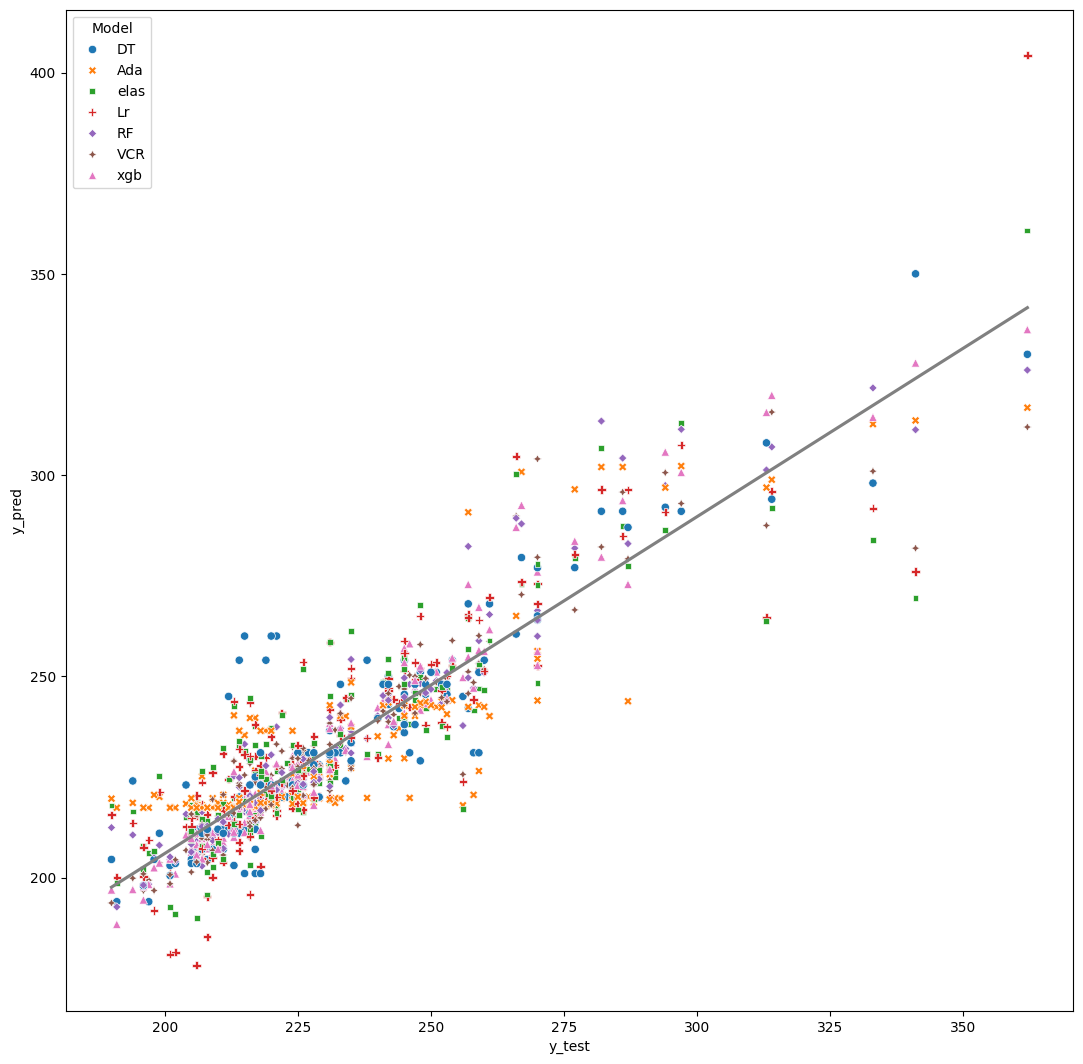

In [554]:
plt.figure(figsize=(13, 13)) 
sns.regplot(data=DT_RF,x='y_test', y='y_pred',scatter=False, ci=None, color='gray')
sns.scatterplot(data=DT_RF, x='y_test', y='y_pred', hue='Model',style='Model')

plt.show()

Epoch 1/10


/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 55868.5703 - mse: 55868.5703 - val_loss: 57217.3086 - val_mse: 57217.3086
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53959.2266 - mse: 53959.2266 - val_loss: 54284.2617 - val_mse: 54284.2617
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51193.8477 - mse: 51193.8477 - val_loss: 45552.5742 - val_mse: 45552.5742
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40863.3438 - mse: 40863.3438 - val_loss: 25252.0215 - val_mse: 25252.0215
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17631.8672 - mse: 17631.8672 - val_loss: 7288.8613 - val_mse: 7288.8613
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5699.1450 - mse: 5699.1450 - val_loss: 5208.4868 - val_mse: 5208.4868
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4064.8955 - mse: 4064.8955 - val_loss: 4320.9561 - val_mse: 4320.9561
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2988.2839 - mse: 2988.2839 - val_loss: 

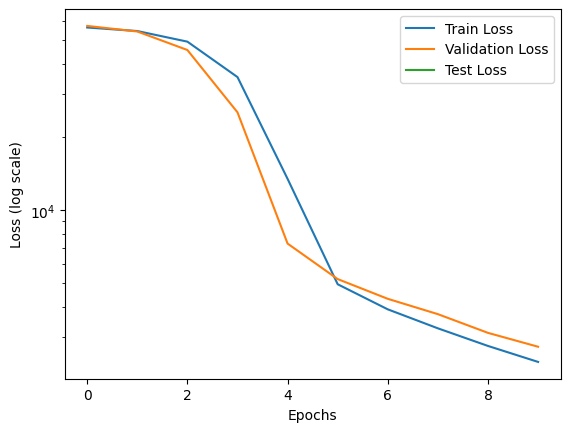

In [ ]:
# NN

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse',metrics=['mse'])

A = model.fit(X_train, y_train, epochs=1, batch_size=16, validation_data=(X_valid, y_valid))
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# 손실값 그래프 
plt.plot(A.history['loss'], label='Train Loss')  
plt.plot(A.history['val_loss'], label='Validation Loss')  
plt.plot(test_loss, label='Test Loss')  
plt.xlabel('Epochs')
plt.ylabel('Loss (log scale)')
plt.yscale('log') 
plt.legend()
plt.show()


In [ ]:
##NN start_time

start_time = time.time()

history = model.fit(X_train, y_train, epochs=270, batch_size=16,
                    validation_data=(X_test, y_test), verbose=1)


y_pred_NN = model.predict(X_test)


rmse_NN = math.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred_NN))
mae_NN = mean_absolute_error(y_true=y_test, y_pred=y_pred_NN)
adj_r2_NN = adj_r2_score(y_true=y_test, y_pred=y_pred_NN)

end_time = time.time()

print(f"Training time: {end_time - start_time: .4f} \n")
print(f"R-squared (R²): {adj_r2_NN} \n")
print(f"mae_NN : {mae_NN } \n")
print(f"rmse_NN: {mae_NN } \n")



# NN
Training time:  76.1754 

R-squared (R²): 0.8179071224327629 

mae_NN : 7.756809711456299 

rmse_NN: 7.756809711456299

### **Time Series Analysis**

In [568]:
# Load file
df = pd.read_csv('data/merged_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop(columns=['Year', 'Month'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
y = df['Avg Power Consumption per Household (kWh)']
y = y.resample('MS').mean()

In [569]:
# Check stationarity using Augmented Dickey-Fuller test
adf = adfuller(y.dropna())
print(f"ADF stats: {adf[0]} | p-val: {adf[1]}")

ADF stats: -0.21625904278285413 | p-val: 0.9365556288116554


In [581]:
# Split into train and test data
date = '2021-01-01'
y_train, y_test = y[:date], y[date:]

In [582]:
# SARIMAX
sarimax = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_fit = sarimax.fit()
print(sarimax_fit.summary())

                                           SARIMAX Results                                           
Dep. Variable:     Avg Power Consumption per Household (kWh)   No. Observations:                   73
Model:                        SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -243.939
Date:                                       Wed, 02 Apr 2025   AIC                            497.879
Time:                                               17:44:10   BIC                            508.350
Sample:                                           01-01-2015   HQIC                           501.975
                                                - 01-01-2021                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2079     

In [583]:
# Forecast
y_pred = sarimax_fit.forecast(steps=len(y_test))
y_pred.index = y_test.index + pd.DateOffset(months=1)

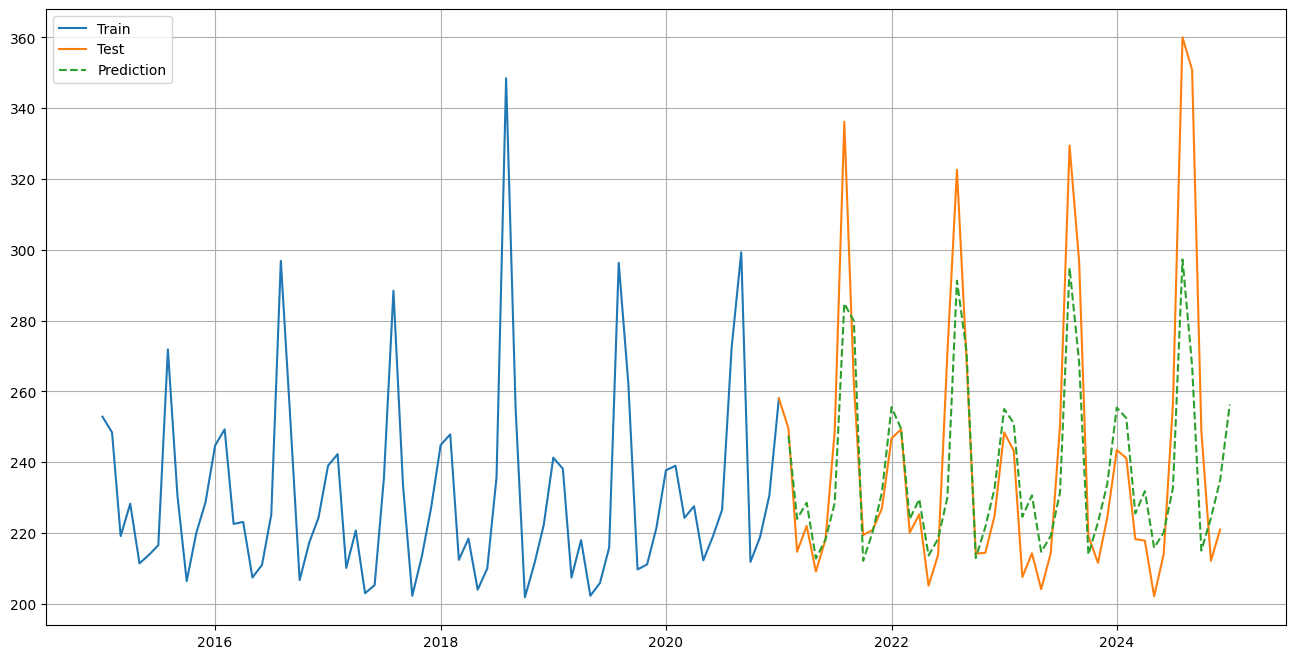

In [584]:
# Forecast
plt.figure(figsize=(16, 8))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(y_pred, label='Prediction', linestyle='--')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Evaluation
y_test = y_test.loc[y_pred.index] 
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

TypeError: cannot do slice indexing on DatetimeIndex with these indexers [DatetimeIndex(['2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01',
               '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01',
               '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
               '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01',
               '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
               '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01',
               '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01',
               '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01',
               '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01',
               '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01',
               '2024-10-01', '2024-11-01', '2024-12-01', '2025-01-01'],
              dtype='datetime64[ns]', name='Date', freq=None)] of type DatetimeIndex